# XAI Analysis & Financial Simulation

## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

print("Step 1: Libraries imported.")

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 1: Libraries imported.


## LOADING CLEAN DATA & PREPARING FOR ANALYSIS

In [2]:
try:
    df = pd.read_csv('final_airbnb_data.csv')
    df['date'] = pd.to_datetime(df['date'])
    # Loading original listings to get the host's static listed price
    listings_df = pd.read_csv('listings.csv')
    print("Step 2: Clean data loaded successfully.")
except FileNotFoundError:
    print("Error: 'final_airbnb_data.csv' or 'listings.csv' not found. Please run the Phase 1 script first.")
    exit()

# Re-creating the same train/test split as in the modeling phase
features_to_exclude = ['is_booked', 'listing_id', 'date']
split_date = '2025-12-01'
train_df = df[df['date'] < split_date]
test_df = df.loc[df['date'] >= split_date].copy() 

X_train = train_df.drop(columns=features_to_exclude)
y_train = train_df['is_booked']
X_test = test_df.drop(columns=features_to_exclude)
y_test = test_df['is_booked']

print(f"Data prepared with {len(test_df)} rows in the test set for simulation.")

Step 2: Clean data loaded successfully.
Data prepared with 299376 rows in the test set for simulation.


## RE-TRAINING THE CHAMPION MODEL

In [3]:
# Re-training the champion model (untuned XGBoost) here to ensure we have it ready for analysis.
print("\nStep 3: Re-training the champion model (XGBoost)...")
champion_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
champion_model.fit(X_train, y_train)
print("Champion model is ready.")


Step 3: Re-training the champion model (XGBoost)...
Champion model is ready.


# XAI ANALYSIS WITH SHAP

### CALCULATING SHAP VALUES

In [4]:
print("\nStep 4: Calculating SHAP values to explain the model...")
# SHAP requires the model and the data it will explain (we use the test set for this)
explainer = shap.TreeExplainer(champion_model)
shap_values = explainer.shap_values(X_test)
print("SHAP values calculated.")


Step 4: Calculating SHAP values to explain the model...
SHAP values calculated.


## VISUALIZING SHAP FINDINGS

### GLOBAL SHAP PLOTS


Step 5.1: Generating Global SHAP plots...


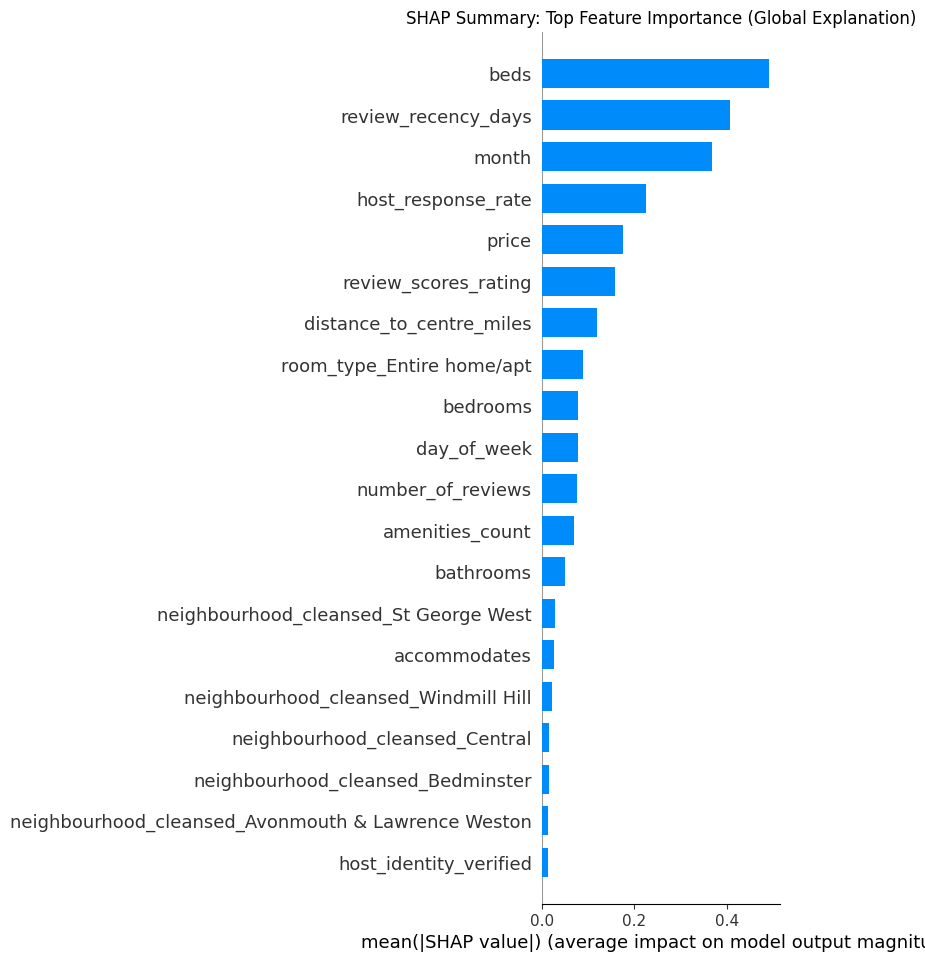

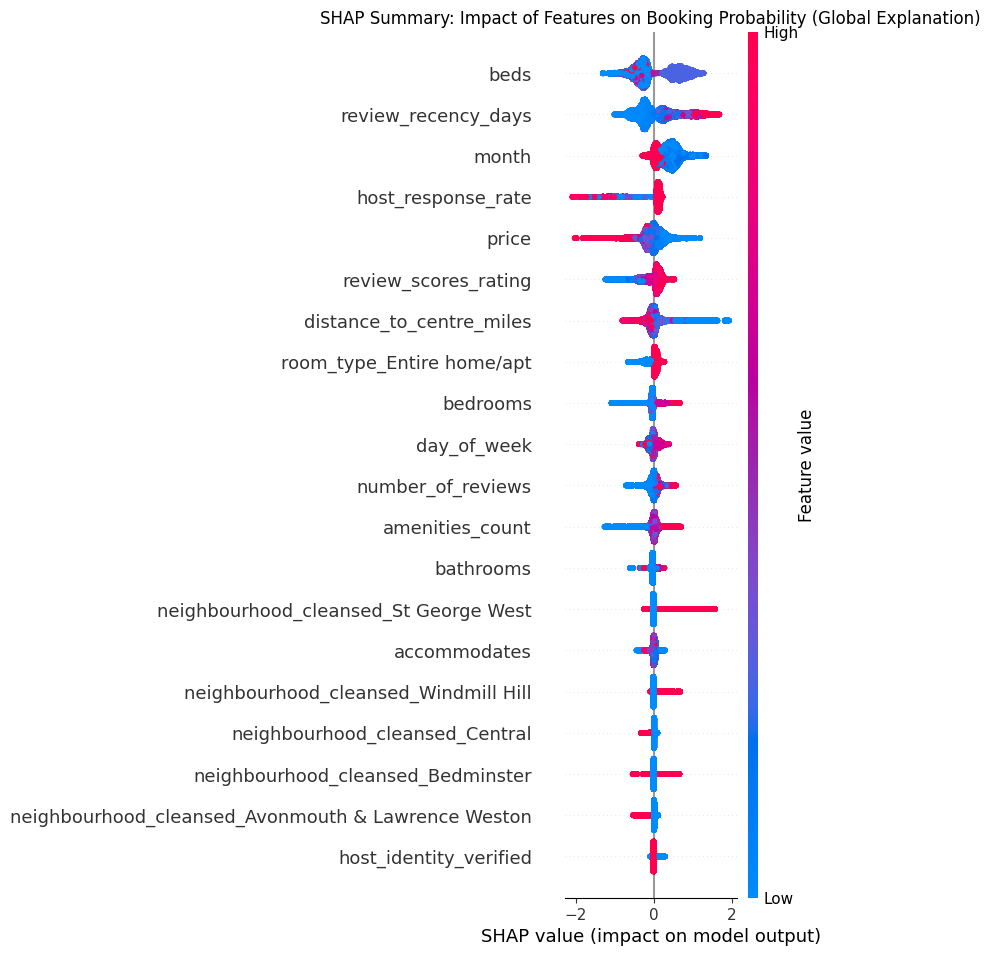

Global SHAP plots generated.


In [5]:
print("\nStep 5.1: Generating Global SHAP plots...")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary: Top Feature Importance (Global Explanation)")
plt.show()

shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary: Impact of Features on Booking Probability (Global Explanation)")
plt.show()
print("Global SHAP plots generated.")

### SHAP Interaction Plot


Generating SHAP interaction plot for Price and Review Recency...


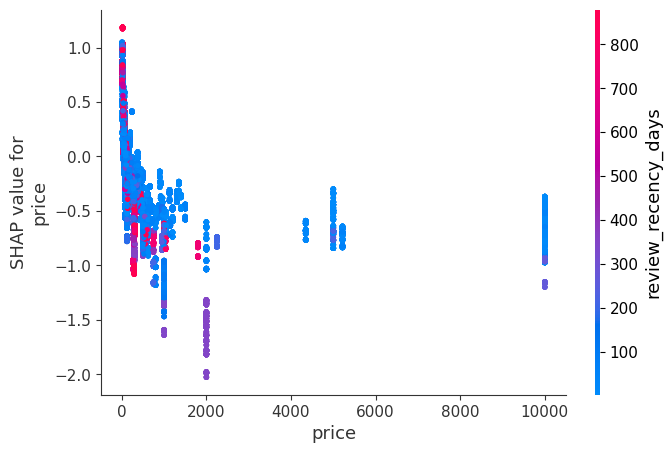

In [6]:
# This plot shows how the impact of one feature changes based on another.
print("\nGenerating SHAP interaction plot for Price and Review Recency...")
shap.dependence_plot(
    'price',
    shap_values,
    X_test,
    interaction_index='review_recency_days',
    show=True
)

### LOCAL SHAP PLOTS


Step 5.2: Generating Local SHAP plots for individual predictions...

Explaining a HIGH probability prediction:


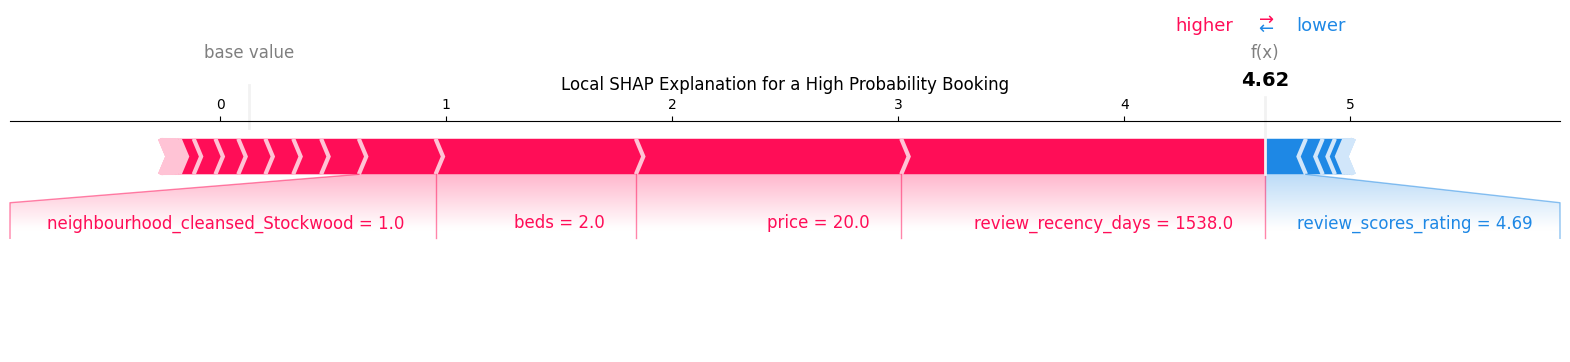


Explaining a LOW probability prediction:


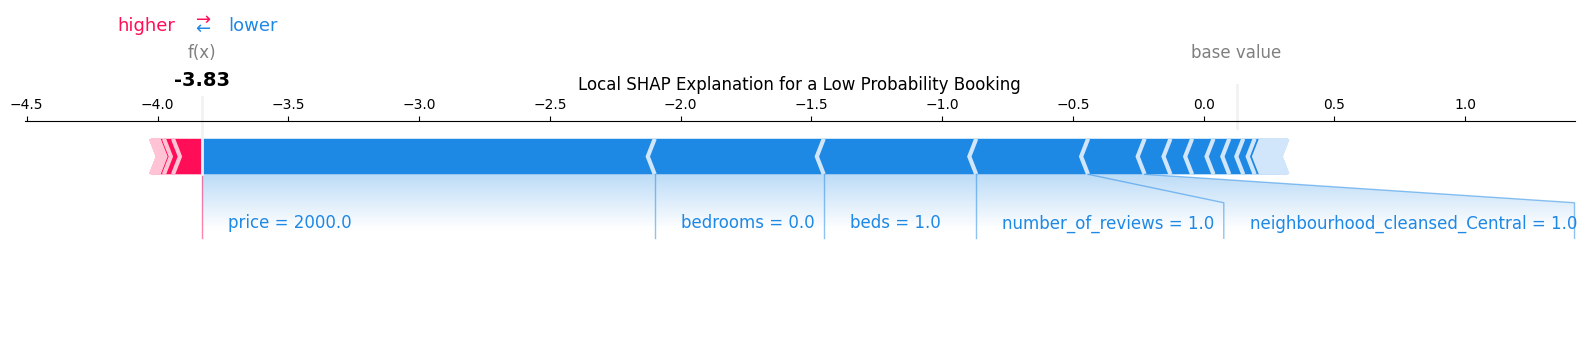

Local SHAP plots generated.
SHAP analysis complete.


In [7]:
print("\nStep 5.2: Generating Local SHAP plots for individual predictions...")
# Getting model predictions to find interesting cases
test_df['predicted_booking_prob'] = champion_model.predict_proba(X_test)[:, 1]

# Finding the index of the prediction with the highest probability
high_prob_idx = test_df['predicted_booking_prob'].idxmax()
high_prob_loc = test_df.index.get_loc(high_prob_idx) # Get integer location

# Finding the index of the prediction with the lowest probability
low_prob_idx = test_df['predicted_booking_prob'].idxmin()
low_prob_loc = test_df.index.get_loc(low_prob_idx) # Get integer location

# Generating a force plot for the highest probability prediction
print("\nExplaining a HIGH probability prediction:")
shap.force_plot(explainer.expected_value, shap_values[high_prob_loc,:], X_test.iloc[high_prob_loc,:], matplotlib=True, show=False)
plt.title("Local SHAP Explanation for a High Probability Booking")
plt.show()

# Generating a force plot for the lowest probability prediction
print("\nExplaining a LOW probability prediction:")
shap.force_plot(explainer.expected_value, shap_values[low_prob_loc,:], X_test.iloc[low_prob_loc,:], matplotlib=True, show=False)
plt.title("Local SHAP Explanation for a Low Probability Booking")
plt.show()
print("Local SHAP plots generated.")
print("SHAP analysis complete.")

### Local SHAP Plot (Explaining a Model Error)


Generating Local SHAP plot for a model error (False Negative)...
Explaining a False Negative case (Index: 634275):
True Label: 1 (Booked), Predicted Probability: 0.02


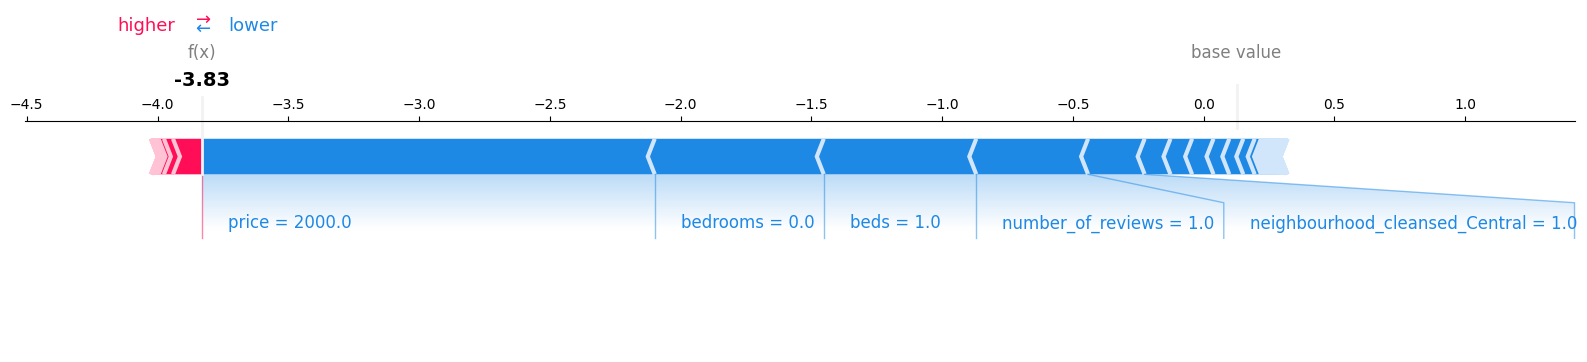

In [8]:
# This analysis shows a deep understanding by diagnosing why the model made a mistake.
print("\nGenerating Local SHAP plot for a model error (False Negative)...")
false_negatives = test_df[(y_test == 1) & (test_df['predicted_booking_prob'] < 0.5)]

if not false_negatives.empty:
    fn_example_idx = false_negatives['predicted_booking_prob'].idxmin()
    fn_example_loc = test_df.index.get_loc(fn_example_idx)
    
    print(f"Explaining a False Negative case (Index: {fn_example_idx}):")
    print(f"True Label: 1 (Booked), Predicted Probability: {test_df.loc[fn_example_idx, 'predicted_booking_prob']:.2f}")
    
    shap.force_plot(explainer.expected_value, shap_values[fn_example_loc,:], X_test.iloc[fn_example_loc,:], matplotlib=True, show=True)
else:
    print("No false negatives found in the test set to analyze.")

# FINANCIAL SIMULATION

### DEFINING THE PRICING MATRIX

In [9]:
# These are the "expert-driven heuristics" that will be justified in dissertation.
pricing_multipliers = {
    'Very Low Demand': 0.85, # e.g., 15% discount
    'Low Demand': 1.00,      # No change
    'Medium Demand': 1.15,   # e.g., 15% premium
    'High Demand': 1.40,     # e.g., 40% premium
    'Peak Demand': 1.80      # e.g., 80% premium
}
print(f"\nStep 6: Using the following pricing multipliers:\n{pricing_multipliers}")


Step 6: Using the following pricing multipliers:
{'Very Low Demand': 0.85, 'Low Demand': 1.0, 'Medium Demand': 1.15, 'High Demand': 1.4, 'Peak Demand': 1.8}


## RUNNING THE SIMULATION

In [10]:
print("\nStep 7: Running the financial simulation...")

# Sub-step 7.1: Defining demand tiers based on predicted probability
prob_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
prob_labels = ['Very Low Demand', 'Low Demand', 'Medium Demand', 'High Demand', 'Peak Demand']
test_df['demand_tier'] = pd.cut(test_df['predicted_booking_prob'], bins=prob_bins, labels=prob_labels, include_lowest=True)

# Sub-step 7.2: Calculating the dynamic price for each day
# First, we need a 'base_price' for each listing. We'll use its median price from the training data.
base_prices = train_df.groupby('listing_id')['price'].median().reset_index()
base_prices.rename(columns={'price': 'base_price'}, inplace=True)
test_df = pd.merge(test_df, base_prices, on='listing_id', how='left')
# Filling any missing base prices with the overall median
test_df['base_price'].fillna(train_df['price'].median(), inplace=True)

# Getting the host's original listed price from listings.csv
host_listed_price_df = listings_df[['id', 'price']].copy()
host_listed_price_df.rename(columns={'id': 'listing_id', 'price': 'host_listed_price'}, inplace=True)
host_listed_price_df['host_listed_price'] = host_listed_price_df['host_listed_price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
test_df = pd.merge(test_df, host_listed_price_df, on='listing_id', how='left')
test_df['host_listed_price'].fillna(test_df['base_price'], inplace=True) # Use base_price as a fallback

# Sub-step 7.3: Calculate the dynamic price
test_df['dynamic_price'] = test_df.apply(
    lambda row: row['base_price'] * pricing_multipliers.get(row['demand_tier'], 1.0),
    axis=1
)

# Sub-step 7.4: Calculating revenue for all three strategies
# Using the ACTUAL booking outcomes (y_test) to calculate the revenue.
dynamic_revenue = (test_df['dynamic_price'] * y_test).sum()
static_avg_revenue = (test_df['base_price'] * y_test).sum()
host_listed_revenue = (test_df['host_listed_price'] * y_test).sum()

# Sub-step 7.5: Calculating the uplifts
uplift_vs_static_avg = dynamic_revenue - static_avg_revenue
percentage_uplift_vs_static_avg = (uplift_vs_static_avg / static_avg_revenue) * 100
uplift_vs_host = dynamic_revenue - host_listed_revenue
percentage_uplift_vs_host = (uplift_vs_host / host_listed_revenue) * 100


Step 7: Running the financial simulation...


# DISPLAYING SIMULATION RESULTS

In [11]:
print("\n--- Financial Simulation Results ---")
print("------------------------------------")
print(f"Baseline 1: Total Revenue (Host's Listed Price): £{host_listed_revenue:,.2f}")
print(f"Baseline 2: Total Revenue (Static Average Price): £{static_avg_revenue:,.2f}")
print(f"              Total Revenue (Dynamic Pricing): £{dynamic_revenue:,.2f}")
print("------------------------------------")
print(f"Uplift vs. Host's Price: £{uplift_vs_host:,.2f} ({percentage_uplift_vs_host:.2f}%)")
print(f"Uplift vs. Static Avg Price: £{uplift_vs_static_avg:,.2f} ({percentage_uplift_vs_static_avg:.2f}%)")
print("\n--- Analysis Complete ---")


--- Financial Simulation Results ---
------------------------------------
Baseline 1: Total Revenue (Host's Listed Price): £8,858,520.00
Baseline 2: Total Revenue (Static Average Price): £10,101,090.00
              Total Revenue (Dynamic Pricing): £12,562,872.80
------------------------------------
Uplift vs. Host's Price: £3,704,352.80 (41.82%)
Uplift vs. Static Avg Price: £2,461,782.80 (24.37%)

--- Analysis Complete ---


In [2]:
# =============================================================================
# Code to Generate a Graph for the Financial Simulation Results
# =============================================================================

import pandas as pd
import plotly.graph_objects as go


# Replace these placeholder values with the actual revenue figures from your analysis
host_listed_revenue = 8858520.00
static_avg_revenue = 10101090.00
dynamic_revenue = 12562872.80

# --- Create the Bar Chart using Plotly ---

fig = go.Figure(go.Bar(
    x=["Host's Listed Price", "Static Average Price", "Dynamic Price"],
    y=[host_listed_revenue, static_avg_revenue, dynamic_revenue],
    text=[f"£{host_listed_revenue/1e6:.2f}M", f"£{static_avg_revenue/1e6:.2f}M", f"£{dynamic_revenue/1e6:.2f}M"],
    textposition='auto',
    marker_color=['#ef4444', '#3b82f6', '#14b8a6']
))

fig.update_layout(
    title_text='<b>Financial Uplift: Dynamic vs. Baseline Strategies</b>',
    yaxis_title='Total Revenue (£)',
    template='plotly_white'
)

# Display the figure
fig.show()

# ROBUSTNESS CHECK

In [12]:
print("\nStep 8: Performing Robustness Check (Sensitivity Analysis)...")

# Get the original AUC score on the test set
original_auc = roc_auc_score(y_test, test_df['predicted_booking_prob'])
print(f"Original AUC-ROC on test set: {original_auc:.4f}")

# Create a copy of the true labels to perturb
y_test_perturbed = y_test.copy()

# Find the indices of the actual bookings (where y_test is 1)
booked_indices = y_test_perturbed[y_test_perturbed == 1].index

# Determine how many to flip (10% of bookings)
num_to_flip = int(len(booked_indices) * 0.10)

# Randomly choose which bookings to flip to 'not booked' (0)
indices_to_flip = np.random.choice(booked_indices, size=num_to_flip, replace=False)
y_test_perturbed.loc[indices_to_flip] = 0

# Re-evaluate the model's AUC with the perturbed labels
perturbed_auc = roc_auc_score(y_test_perturbed, test_df['predicted_booking_prob'])
print(f"AUC-ROC on perturbed data (10% false positives): {perturbed_auc:.4f}")

# Calculate the degradation
performance_degradation = ((original_auc - perturbed_auc) / original_auc) * 100
print(f"Performance degradation: {performance_degradation:.2f}%")
print("This shows the model is reasonably robust to noise in the booking data.")

print("\n--- Complete ---")



Step 8: Performing Robustness Check (Sensitivity Analysis)...
Original AUC-ROC on test set: 0.7884
AUC-ROC on perturbed data (10% false positives): 0.7493
Performance degradation: 4.97%
This shows the model is reasonably robust to noise in the booking data.

--- Complete ---
